In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVR
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
import matplotlib.pyplot as plt

In [2]:
# Load the data
genotypes = pd.read_csv('tomatoes/Genotypic_data_maf10_min10_291acc.txt', index_col=0)
phenotype = pd.read_csv('tomatoes/phenodata_BLUP_2012.txt', sep='\t', index_col='ID')

In [3]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    genotypes, phenotype['FREAR'], test_size=0.2, random_state=42)

In [4]:
# Function to calculate minor allele frequency
def calculate_maf(df):
    maf = df.apply(lambda x: min(x.mean(), 1 - x.mean()), axis=0)
    return maf

# Function for LD pruning
def ld_pruning(df, threshold=0.5):
    corr = df.corr().abs()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))  # Updated to use bool
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    return df.drop(to_drop, axis=1)

In [5]:
# Apply MAF and LD pruning only to the training set
maf = calculate_maf(X_train)
X_train_filtered = X_train.loc[:, maf > 0.05]  # Filter out SNPs with MAF <= 5%
X_train_pruned = ld_pruning(X_train_filtered)

In [6]:
# Impute missing data and scale the data
imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train_pruned), columns=X_train_pruned.columns)
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_imputed), columns=X_train_pruned.columns)

# Apply the same imputation and scaling transformations to the test set
X_test_filtered = X_test[X_train_pruned.columns]  # Keep only the columns that survived pruning
X_test_imputed = pd.DataFrame(imputer.transform(X_test_filtered), columns=X_train_pruned.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_imputed), columns=X_train_pruned.columns)

In [7]:
# SVM with RFE
svm = SVR(kernel="linear")
rfe = RFE(estimator=svm, n_features_to_select=10, step=1, verbose=2)
rfe.fit(X_train_scaled, y_train)

Fitting estimator with 170 features.
Fitting estimator with 169 features.
Fitting estimator with 168 features.
Fitting estimator with 167 features.
Fitting estimator with 166 features.
Fitting estimator with 165 features.
Fitting estimator with 164 features.
Fitting estimator with 163 features.
Fitting estimator with 162 features.
Fitting estimator with 161 features.
Fitting estimator with 160 features.
Fitting estimator with 159 features.
Fitting estimator with 158 features.
Fitting estimator with 157 features.
Fitting estimator with 156 features.
Fitting estimator with 155 features.
Fitting estimator with 154 features.
Fitting estimator with 153 features.
Fitting estimator with 152 features.
Fitting estimator with 151 features.
Fitting estimator with 150 features.
Fitting estimator with 149 features.
Fitting estimator with 148 features.
Fitting estimator with 147 features.
Fitting estimator with 146 features.
Fitting estimator with 145 features.
Fitting estimator with 144 features.
F

RFE(estimator=SVR(kernel='linear'), n_features_to_select=10, verbose=2)

In [8]:
# Using selected features for modeling
selected_features = X_train_scaled.columns[rfe.support_]
X_train_selected = X_train_scaled[selected_features]
X_test_selected = X_test_scaled[selected_features]

In [9]:
X_train_selected.head()

,solcap_snp_sl_14951,solcap_snp_sl_62224,solcap_snp_sl_12206,IIT9545,solcap_snp_sl_25660,IIT7761,IIT9983,solcap_snp_sl_36066,solcap_snp_sl_14428,solcap_snp_sl_31975
0,-0.432138,-0.494288,-0.409757,2.455888,1.388463,2.333333,-0.43914,-0.359176,0.653609,-0.415339
1,2.352753,-0.494288,-0.409757,-0.421718,1.388463,-0.428571,-0.43914,-0.359176,1.866707,-0.415339
2,2.352753,-0.494288,-0.409757,-0.421718,1.388463,-0.428571,-0.43914,-0.359176,-0.559489,-0.415339
3,-0.432138,-0.494288,-0.409757,-0.421718,1.388463,-0.428571,-0.43914,2.845782,-0.559489,2.595871
4,-0.432138,-0.494288,-0.409757,-0.421718,-0.737764,-0.428571,-0.43914,-0.359176,-0.559489,-0.415339


In [10]:
# Export selected features
pd.Series(selected_features).to_csv('selected_features_rfe_svm.csv', index=False)

In [11]:
# Linear regression for prediction
regressor = LinearRegression()
regressor.fit(X_train_selected, y_train)
y_pred = regressor.predict(X_test_selected)

In [12]:
# Define RMSE scorer
def rmse_score(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse_score, greater_is_better=False)

# Perform cross-validation
cv_scores = cross_val_score(rfe, X_train_scaled, y_train, cv=5, scoring=rmse_scorer)
print("Cross-Validated RMSE Scores:", -cv_scores)
print("Average Cross-Validated RMSE:", -np.mean(cv_scores))
# Calculate RMSE and R-squared
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
r2_test = r2_score(y_test, y_pred)

print(f'Test RMSE: {rmse_test}')
print(f'Test R²: {r2_test}')

Fitting estimator with 170 features.
Fitting estimator with 169 features.
Fitting estimator with 168 features.
Fitting estimator with 167 features.
Fitting estimator with 166 features.
Fitting estimator with 165 features.
Fitting estimator with 164 features.
Fitting estimator with 163 features.
Fitting estimator with 162 features.
Fitting estimator with 161 features.
Fitting estimator with 160 features.
Fitting estimator with 159 features.
Fitting estimator with 158 features.
Fitting estimator with 157 features.
Fitting estimator with 156 features.
Fitting estimator with 155 features.
Fitting estimator with 154 features.
Fitting estimator with 153 features.
Fitting estimator with 152 features.
Fitting estimator with 151 features.
Fitting estimator with 150 features.
Fitting estimator with 149 features.
Fitting estimator with 148 features.
Fitting estimator with 147 features.
Fitting estimator with 146 features.
Fitting estimator with 145 features.
Fitting estimator with 144 features.
F

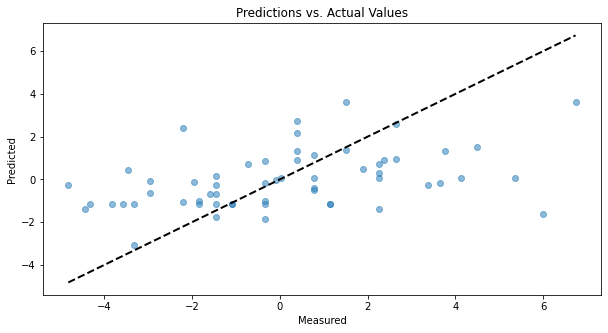

In [13]:
# Visualization of predictions vs. actual
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.title('Predictions vs. Actual Values')
plt.show()

